In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from datetime import datetime, timedelta

In [2]:
def parse_filename_coordinates(filename):
    """Extract lat/lon from filename like 'clim_76.80_32.20.dat'"""
    name = Path(filename).stem  # Remove .dat extension
    
    # Split by underscore: ['clim', '76.80', '32.20']
    parts = name.split('_')
    
    if len(parts) != 3:
        raise ValueError(f"Expected format 'clim_lon_lat', got: {name}")
    
    # Get lon and lat parts
    lon_str = parts[1]  # '76.80'
    lat_str = parts[2]  # '32.20'
    
    return float(lon_str), float(lat_str)

In [3]:
def read_climate_dat_file(filepath):
    """Read a single .dat climate file"""
    # Read the file, skipping header lines
    df = pd.read_csv(filepath, sep='\s+', skiprows=3, 
                     names=['Year', 'Month', 'DOY', 'decimal_time', 
                            'temp_degC', 'prec_mm', 'dT_dz'])
    
    # CORRECT: Create datetime from Year + DOY (Day of Year)
    df['date'] = pd.to_datetime(df['Year'], format='%Y') + pd.to_timedelta(df['DOY'] - 1, unit='D')
    
    return df

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1550581/2977282388.py:4: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(filepath, sep='\s+', skiprows=3,


In [5]:
def load_all_climate_data(data_dir, start_date=None, end_date=None):
    """
    Load all climate .dat files and create spatial dataset
    
    Parameters
    ----------
    data_dir : str or Path
        Directory containing .dat files
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str  
        End date in 'YYYY-MM-DD' format
        
    Returns
    -------
    xr.Dataset
        Spatial climate dataset
    """
    data_dir = Path(data_dir)
    
    # Find all .dat files
    dat_files = list(data_dir.glob("clim_*.dat"))
    print(f"Found {len(dat_files)} climate data files")
    
    if not dat_files:
        raise ValueError(f"No .dat files found in {data_dir}")
    
    # Process each file
    all_data = []
    coordinates = []
    
    for file_path in dat_files:
        try:
            # Extract coordinates from filename
            lon, lat = parse_filename_coordinates(file_path)
            coordinates.append((lon, lat))
            
            # Read the data
            df = read_climate_dat_file(file_path)
            
            # Filter by date range if specified
            if start_date:
                df = df[df['date'] >= pd.to_datetime(start_date)]
            if end_date:
                df = df[df['date'] <= pd.to_datetime(end_date)]
            
            # Add coordinates to dataframe
            df['lon'] = lon
            df['lat'] = lat
            
            all_data.append(df)
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    if not all_data:
        raise ValueError("No data could be loaded from files")
    
    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Create spatial dataset
    # Get unique coordinates and times
    unique_lons = sorted(combined_df['lon'].unique())
    unique_lats = sorted(combined_df['lat'].unique())
    unique_times = sorted(combined_df['date'].unique())
    
    print(f"Grid dimensions: {len(unique_lons)} x {len(unique_lats)} = {len(unique_lons)*len(unique_lats)} cells")
    print(f"Time range: {unique_times[0]} to {unique_times[-1]} ({len(unique_times)} days)")
    print(f"Longitude range: {min(unique_lons):.2f} to {max(unique_lons):.2f}")
    print(f"Latitude range: {min(unique_lats):.2f} to {max(unique_lats):.2f}")
    
    # Create empty arrays
    temp_array = np.full((len(unique_times), len(unique_lats), len(unique_lons)), np.nan)
    prec_array = np.full((len(unique_times), len(unique_lats), len(unique_lons)), np.nan)
    
    # Fill arrays
    for _, row in combined_df.iterrows():
        time_idx = unique_times.index(row['date'])
        lat_idx = unique_lats.index(row['lat'])
        lon_idx = unique_lons.index(row['lon'])
        
        temp_array[time_idx, lat_idx, lon_idx] = row['temp_degC']
        prec_array[time_idx, lat_idx, lon_idx] = row['prec_mm']
    
    # Create xarray Dataset
    ds = xr.Dataset({
        'temperature': (['time', 'latitude', 'longitude'], temp_array, 
                       {'units': 'degC', 'long_name': 'Daily mean temperature'}),
        'precipitation': (['time', 'latitude', 'longitude'], prec_array,
                         {'units': 'mm', 'long_name': 'Daily precipitation'})
    }, coords={
        'time': unique_times,
        'latitude': unique_lats,
        'longitude': unique_lons
    })
    
    return ds

In [6]:
def calculate_climate_statistics(ds, variable='temperature'):
    """Calculate spatial climate statistics"""
    data = ds[variable]
    
    stats = {
        'mean': data.mean(dim='time'),
        'std': data.std(dim='time'),
        'min': data.min(dim='time'),
        'max': data.max(dim='time'),
        'median': data.median(dim='time')
    }
    
    return stats

In [7]:
def plot_climate_comparison(climate_ds, netcdf_ds=None, variable='temperature', 
                           save_path=None):
    """Plot spatial climate data and optionally compare with NetCDF - NO CARTOPY VERSION"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Calculate statistics
    stats = calculate_climate_statistics(climate_ds, variable)
    
    # Plot settings
    if variable == 'temperature':
        cmap = 'RdBu_r'
        unit = '°C'
    else:
        cmap = 'Blues'
        unit = 'mm'
    
    # Plot mean
    im1 = axes[0].pcolormesh(climate_ds.longitude, climate_ds.latitude, 
                            stats['mean'], cmap=cmap)
    axes[0].set_title(f'Climate Data - Mean {variable.title()} ({unit})')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(im1, ax=axes[0], shrink=0.7)
    
    # Plot standard deviation
    im2 = axes[1].pcolormesh(climate_ds.longitude, climate_ds.latitude, 
                            stats['std'], cmap='viridis')
    axes[1].set_title(f'Climate Data - Std {variable.title()} ({unit})')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(im2, ax=axes[1], shrink=0.7)
    
    # If NetCDF data provided, plot comparison
    if netcdf_ds is not None and variable in netcdf_ds:
        # Calculate NetCDF mean (assuming it has time dimension)
        if 'time' in netcdf_ds[variable].dims:
            netcdf_mean = netcdf_ds[variable].mean(dim='time')
        else:
            netcdf_mean = netcdf_ds[variable]
            
        im3 = axes[2].pcolormesh(netcdf_ds.longitude, netcdf_ds.latitude, 
                                netcdf_mean, cmap=cmap)
        axes[2].set_title(f'NetCDF Data - Mean {variable.title()} ({unit})')
        axes[2].set_xlabel('Longitude')
        axes[2].set_ylabel('Latitude')
        axes[2].grid(True, alpha=0.3)
        plt.colorbar(im3, ax=axes[2], shrink=0.7)
        
        # Plot difference
        # Interpolate climate data to NetCDF grid for comparison
        climate_interp = stats['mean'].interp(longitude=netcdf_ds.longitude, 
                                            latitude=netcdf_ds.latitude)
        diff = climate_interp - netcdf_mean
        
        im4 = axes[3].pcolormesh(netcdf_ds.longitude, netcdf_ds.latitude, 
                                diff, cmap='RdBu_r')
        axes[3].set_title(f'Difference (Climate - NetCDF) ({unit})')
        axes[3].set_xlabel('Longitude')
        axes[3].set_ylabel('Latitude')
        axes[3].grid(True, alpha=0.3)
        plt.colorbar(im4, ax=axes[3], shrink=0.7)
    else:
        # Plot min and max
        im3 = axes[2].pcolormesh(climate_ds.longitude, climate_ds.latitude, 
                                stats['min'], cmap=cmap)
        axes[2].set_title(f'Climate Data - Min {variable.title()} ({unit})')
        axes[2].set_xlabel('Longitude')
        axes[2].set_ylabel('Latitude')
        axes[2].grid(True, alpha=0.3)
        plt.colorbar(im3, ax=axes[2], shrink=0.7)
        
        im4 = axes[3].pcolormesh(climate_ds.longitude, climate_ds.latitude, 
                                stats['max'], cmap=cmap)
        axes[3].set_title(f'Climate Data - Max {variable.title()} ({unit})')
        axes[3].set_xlabel('Longitude')
        axes[3].set_ylabel('Latitude')
        axes[3].grid(True, alpha=0.3)
        plt.colorbar(im4, ax=axes[3], shrink=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()

In [8]:
def print_climate_summary(climate_ds):
    """Print detailed climate statistics"""
    print("\n" + "="*50)
    print("CLIMATE DATA SUMMARY")
    print("="*50)
    
    print(f"\nDataset dimensions: {dict(climate_ds.dims)}")
    
    # Temperature statistics
    temp_stats = calculate_climate_statistics(climate_ds, 'temperature')
    print(f"\n📊 TEMPERATURE STATISTICS (°C):")
    print(f"  Spatial mean:     {temp_stats['mean'].mean().values:.2f}")
    print(f"  Spatial std:      {temp_stats['std'].mean().values:.2f}")
    print(f"  Absolute min:     {temp_stats['min'].min().values:.2f}")
    print(f"  Absolute max:     {temp_stats['max'].max().values:.2f}")
    print(f"  Coldest location: {temp_stats['mean'].min().values:.2f}")
    print(f"  Warmest location: {temp_stats['mean'].max().values:.2f}")
    
    # Precipitation statistics  
    prec_stats = calculate_climate_statistics(climate_ds, 'precipitation')
    print(f"\n🌧️  PRECIPITATION STATISTICS (mm):")
    print(f"  Spatial mean:     {prec_stats['mean'].mean().values:.2f}")
    print(f"  Spatial std:      {prec_stats['std'].mean().values:.2f}")
    print(f"  Absolute min:     {prec_stats['min'].min().values:.2f}")
    print(f"  Absolute max:     {prec_stats['max'].max().values:.2f}")
    print(f"  Driest location:  {prec_stats['mean'].min().values:.2f}")
    print(f"  Wettest location: {prec_stats['mean'].max().values:.2f}")
    
    # Additional time series stats
    temp_time_mean = climate_ds['temperature'].mean(dim=['latitude', 'longitude'])
    prec_time_mean = climate_ds['precipitation'].mean(dim=['latitude', 'longitude'])
    
    print(f"\n📈 TIME SERIES STATISTICS:")
    print(f"  Temperature range: {temp_time_mean.min().values:.2f} to {temp_time_mean.max().values:.2f} °C")
    print(f"  Precipitation range: {prec_time_mean.min().values:.2f} to {prec_time_mean.max().values:.2f} mm")
    
    return temp_stats, prec_stats

In [9]:
# Define your parameters
data_directory = "/run/user/1001/gvfs/smb-share:server=fileserv02.giub.unibe.ch,share=userdata/jberg/Meteo_data/drive-download-20250908T185917Z-1-001"
start_date = "2016-06-01"  # Adjust to match your NetCDF period
end_date = "2022-12-31"    # Adjust to match your NetCDF period


In [10]:
# Load and process the data
print("Loading climate data...")
climate_ds = load_all_climate_data(data_directory, start_date, end_date)


Loading climate data...
Found 104 climate data files
Grid dimensions: 12 x 10 = 120 cells
Time range: 2016-06-01 00:00:00 to 2022-12-31 00:00:00 (2403 days)
Longitude range: 76.80 to 77.90
Latitude range: 32.00 to 32.90


In [11]:
# Print comprehensive summary
temp_stats, prec_stats = print_climate_summary(climate_ds)


CLIMATE DATA SUMMARY

Dataset dimensions: {'time': 2403, 'latitude': 10, 'longitude': 12}

📊 TEMPERATURE STATISTICS (°C):
  Spatial mean:     -8.64
  Spatial std:      9.65
  Absolute min:     -38.73
  Absolute max:     14.25
  Coldest location: -14.11
  Warmest location: 1.76

🌧️  PRECIPITATION STATISTICS (mm):
  Spatial mean:     2.98
  Spatial std:      6.05
  Absolute min:     0.00
  Absolute max:     172.60
  Driest location:  1.14
  Wettest location: 6.91

📈 TIME SERIES STATISTICS:
  Temperature range: -30.76 to 8.34 °C
  Precipitation range: 0.00 to 90.70 mm


/tmp/ipykernel_1550581/1265077193.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"\nDataset dimensions: {dict(climate_ds.dims)}")
/home/jberg/miniconda3/envs/Raven-Switzerland/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jberg/miniconda3/envs/Raven-Switzerland/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



Generating plots...


/home/jberg/miniconda3/envs/Raven-Switzerland/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Plot saved to climate_temperature_comparison.png


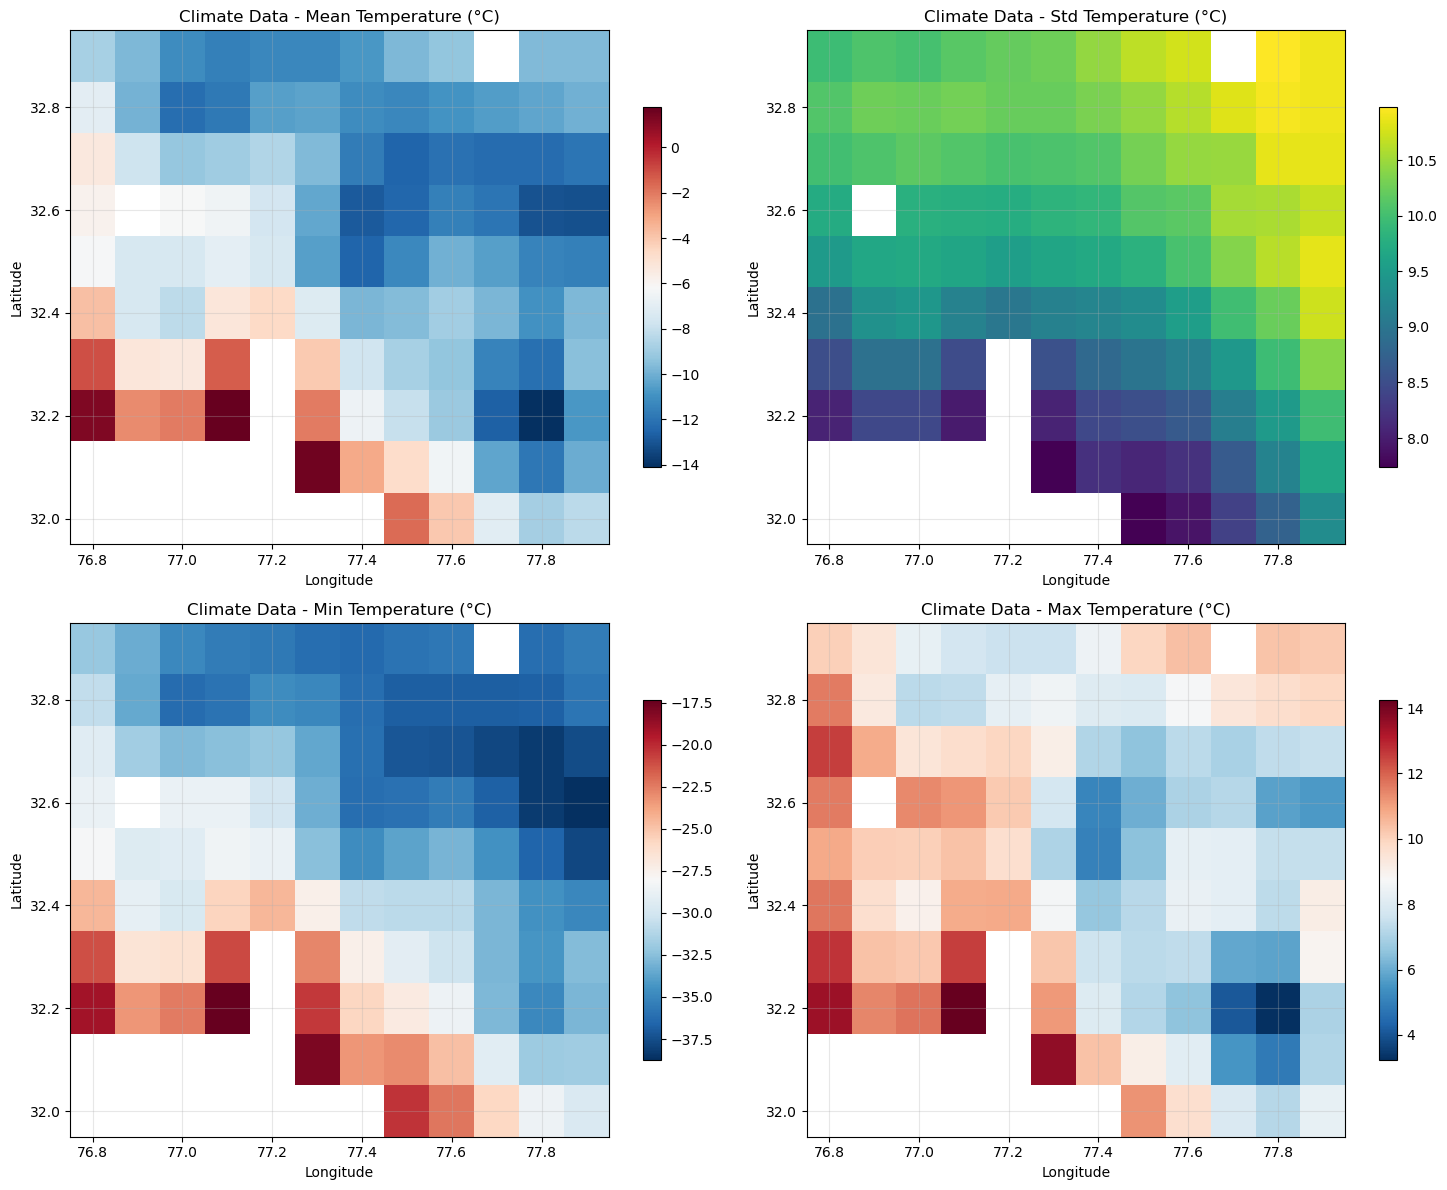

/home/jberg/miniconda3/envs/Raven-Switzerland/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Plot saved to climate_precipitation_comparison.png


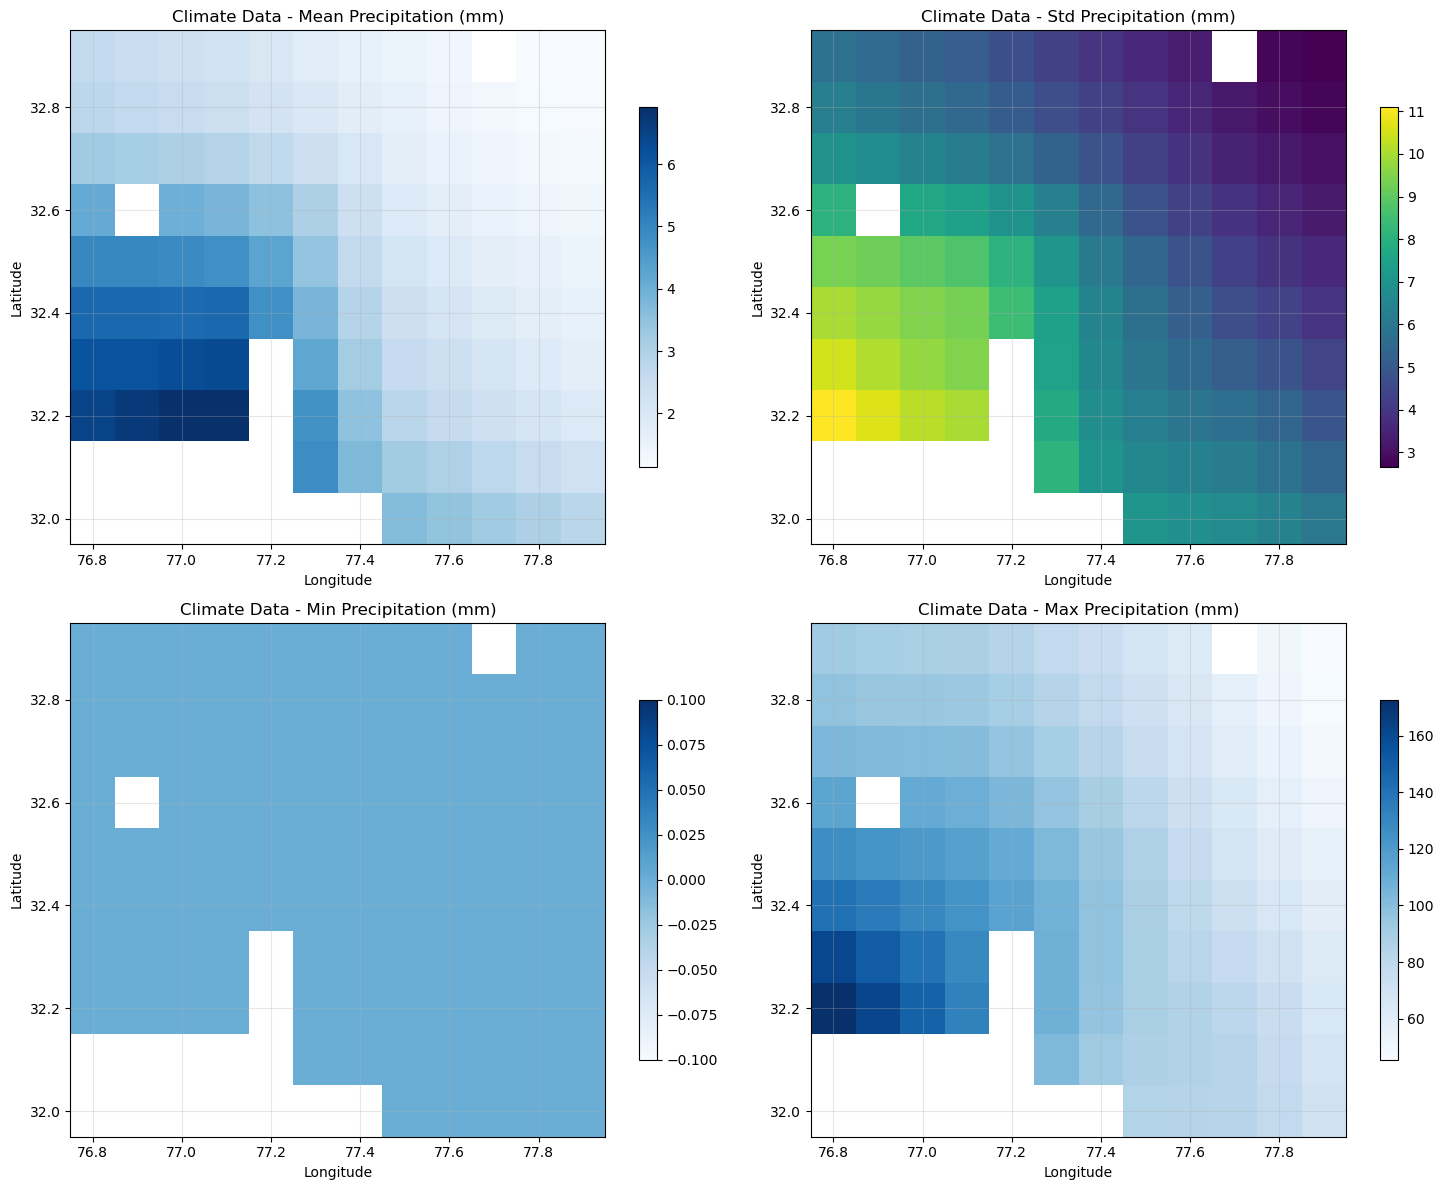

In [12]:
# Generate plots
print("\nGenerating plots...")
plot_climate_comparison(climate_ds, variable='temperature', 
                       save_path='climate_temperature_comparison.png')
plot_climate_comparison(climate_ds, variable='precipitation', 
                       save_path='climate_precipitation_comparison.png')


In [13]:
def calculate_and_plot_time_series(climate_ds, save_path=None):
    """
    Calculate and plot time series of area-averaged temperature and precipitation
    
    Parameters
    ----------
    climate_ds : xr.Dataset
        Climate dataset with temperature and precipitation
    save_path : str, optional
        Path to save the plot
    """
    # Calculate area-averaged time series
    temp_ts = climate_ds['temperature'].mean(dim=['latitude', 'longitude'])
    prec_ts = climate_ds['precipitation'].mean(dim=['latitude', 'longitude'])
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot temperature time series
    temp_ts.plot(ax=ax1, color='red', linewidth=1)
    ax1.set_title('Area-Averaged Daily Temperature Time Series', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Temperature (°C)')
    ax1.grid(True, alpha=0.3)
    
    # Add temperature statistics as text
    temp_stats_text = f"Mean: {temp_ts.mean().values:.2f}°C\n"
    temp_stats_text += f"Std: {temp_ts.std().values:.2f}°C\n"
    temp_stats_text += f"Min: {temp_ts.min().values:.2f}°C\n"
    temp_stats_text += f"Max: {temp_ts.max().values:.2f}°C"
    
    ax1.text(0.02, 0.98, temp_stats_text, transform=ax1.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Plot precipitation time series
    prec_ts.plot(ax=ax2, color='blue', linewidth=1)
    ax2.set_title('Area-Averaged Daily Precipitation Time Series', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Precipitation (mm)')
    ax2.grid(True, alpha=0.3)
    
    # Add precipitation statistics as text
    prec_stats_text = f"Mean: {prec_ts.mean().values:.2f} mm/day\n"
    prec_stats_text += f"Std: {prec_ts.std().values:.2f} mm/day\n"
    prec_stats_text += f"Min: {prec_ts.min().values:.2f} mm/day\n"
    prec_stats_text += f"Max: {prec_ts.max().values:.2f} mm/day"
    
    ax2.text(0.02, 0.98, prec_stats_text, transform=ax2.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Time series plot saved to {save_path}")
    
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("AREA-AVERAGED TIME SERIES STATISTICS")
    print("="*60)
    
    print(f"\n🌡️  TEMPERATURE TIME SERIES:")
    print(f"  Mean:     {temp_ts.mean().values:.2f} °C")
    print(f"  Std Dev:  {temp_ts.std().values:.2f} °C")
    print(f"  Minimum:  {temp_ts.min().values:.2f} °C on {temp_ts.idxmin().values}")
    print(f"  Maximum:  {temp_ts.max().values:.2f} °C on {temp_ts.idxmax().values}")
    
    print(f"\n🌧️  PRECIPITATION TIME SERIES:")
    print(f"  Mean:     {prec_ts.mean().values:.2f} mm/day")
    print(f"  Std Dev:  {prec_ts.std().values:.2f} mm/day") 
    print(f"  Minimum:  {prec_ts.min().values:.2f} mm/day on {prec_ts.idxmin().values}")
    print(f"  Maximum:  {prec_ts.max().values:.2f} mm/day on {prec_ts.idxmax().values}")
    
    # Calculate seasonal statistics
    temp_monthly = temp_ts.groupby('time.month').mean()
    prec_monthly = prec_ts.groupby('time.month').mean()
    
    print(f"\n📅 SEASONAL PATTERNS:")
    print(f"  Warmest month:  {temp_monthly.idxmax().values} ({temp_monthly.max().values:.2f}°C)")
    print(f"  Coldest month:  {temp_monthly.idxmin().values} ({temp_monthly.min().values:.2f}°C)")
    print(f"  Wettest month:  {prec_monthly.idxmax().values} ({prec_monthly.max().values:.2f} mm/day)")
    print(f"  Driest month:   {prec_monthly.idxmin().values} ({prec_monthly.min().values:.2f} mm/day)")
    
    # Calculate annual totals
    prec_annual = prec_ts.groupby('time.year').sum()
    temp_annual = temp_ts.groupby('time.year').mean()
    
    print(f"\n📊 ANNUAL STATISTICS:")
    print(f"  Years analyzed: {len(prec_annual)}")
    print(f"  Mean annual precipitation: {prec_annual.mean().values:.1f} mm/year")
    print(f"  Mean annual temperature:   {temp_annual.mean().values:.2f} °C")
    print(f"  Wettest year: {prec_annual.idxmax().values} ({prec_annual.max().values:.1f} mm)")
    print(f"  Driest year:  {prec_annual.idxmin().values} ({prec_annual.min().values:.1f} mm)")
    print(f"  Warmest year: {temp_annual.idxmax().values} ({temp_annual.max().values:.2f} °C)")
    print(f"  Coldest year: {temp_annual.idxmin().values} ({temp_annual.min().values:.2f} °C)")
    
    return temp_ts, prec_ts

def plot_monthly_climatology(climate_ds, save_path=None):
    """Plot monthly climatology (average seasonal cycle)"""
    # Calculate area-averaged time series
    temp_ts = climate_ds['temperature'].mean(dim=['latitude', 'longitude'])
    prec_ts = climate_ds['precipitation'].mean(dim=['latitude', 'longitude'])
    
    # Calculate monthly climatology
    temp_monthly = temp_ts.groupby('time.month').mean()
    prec_monthly = prec_ts.groupby('time.month').mean()
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot temperature climatology
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    ax1.plot(range(1, 13), temp_monthly.values, 'ro-', linewidth=2, markersize=6)
    ax1.set_title('Monthly Temperature Climatology', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels(months)
    ax1.grid(True, alpha=0.3)
    
    # Plot precipitation climatology
    ax2.bar(range(1, 13), prec_monthly.values, color='blue', alpha=0.7)
    ax2.set_title('Monthly Precipitation Climatology', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Precipitation (mm/day)')
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(months)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Monthly climatology plot saved to {save_path}")
    
    plt.show()

Time series plot saved to area_averaged_time_series.png


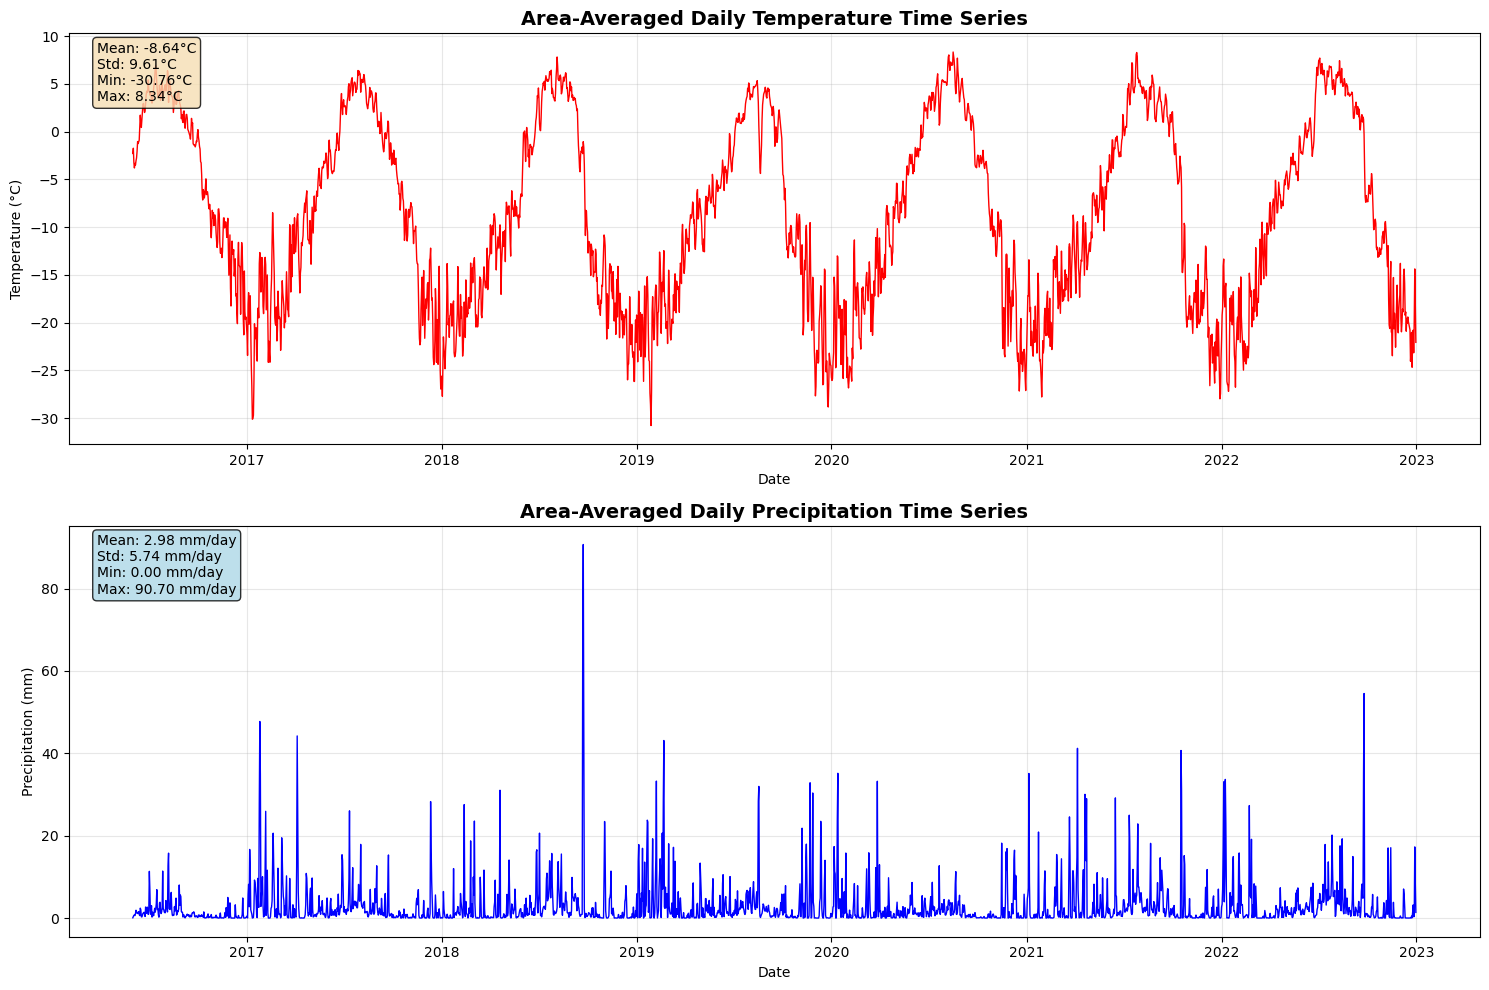


AREA-AVERAGED TIME SERIES STATISTICS

🌡️  TEMPERATURE TIME SERIES:
  Mean:     -8.64 °C
  Std Dev:  9.61 °C
  Minimum:  -30.76 °C on 2019-01-28T00:00:00.000000000
  Maximum:  8.34 °C on 2020-08-16T00:00:00.000000000

🌧️  PRECIPITATION TIME SERIES:
  Mean:     2.98 mm/day
  Std Dev:  5.74 mm/day
  Minimum:  0.00 mm/day on 2016-11-18T00:00:00.000000000
  Maximum:  90.70 mm/day on 2018-09-23T00:00:00.000000000

📅 SEASONAL PATTERNS:
  Warmest month:  8.0 (4.40°C)
  Coldest month:  1.0 (-20.74°C)
  Wettest month:  1.0 (5.08 mm/day)
  Driest month:   10.0 (1.06 mm/day)

📊 ANNUAL STATISTICS:
  Years analyzed: 7
  Mean annual precipitation: 1024.7 mm/year
  Mean annual temperature:   -8.32 °C
  Wettest year: 2019.0 (1329.5 mm)
  Driest year:  2016.0 (289.3 mm)
  Warmest year: 2016.0 (-3.29 °C)
  Coldest year: 2018.0 (-10.02 °C)


In [14]:
temp_ts, prec_ts = calculate_and_plot_time_series(climate_ds, 
                                                  save_path='area_averaged_time_series.png')

Monthly climatology plot saved to monthly_climatology.png


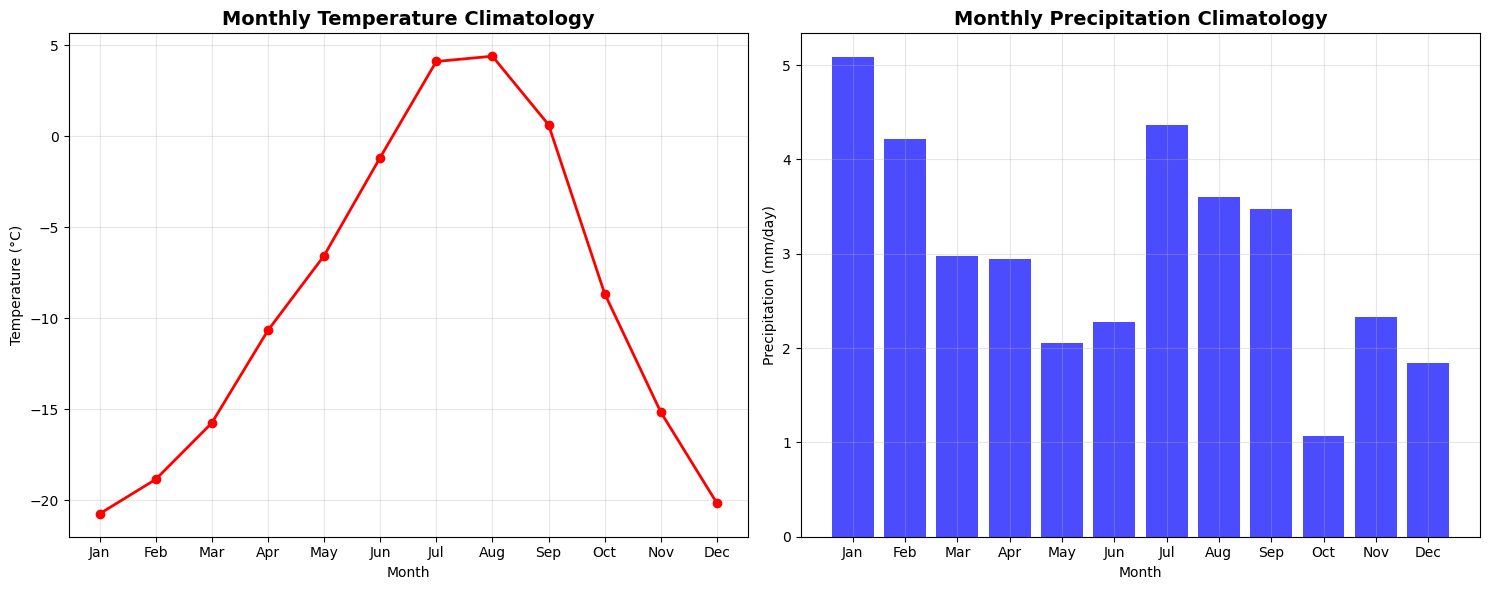

In [15]:
plot_monthly_climatology(climate_ds, save_path='monthly_climatology.png')

In [16]:
# Load ERA5-Land NetCDF data
def load_era5_netcdf_data(netcdf_dir, start_date=None, end_date=None):
    """
    Load ERA5-Land NetCDF files for temperature and precipitation
    
    Parameters
    ----------
    netcdf_dir : str or Path
        Directory containing the NetCDF files
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str  
        End date in 'YYYY-MM-DD' format
        
    Returns
    -------
    xr.Dataset
        Combined ERA5-Land dataset
    """
    netcdf_dir = Path(netcdf_dir)
    
    # Load temperature and precipitation files
    temp_file = netcdf_dir / 'era5_land_temp_mean.nc'
    precip_file = netcdf_dir / 'era5_land_precip.nc'
    
    print(f"Loading ERA5-Land data from {netcdf_dir}")
    
    # Load datasets
    ds_temp = xr.open_dataset(temp_file)
    ds_precip = xr.open_dataset(precip_file)
    
    print(f"Temperature dataset: {dict(ds_temp.dims)}")
    print(f"Temperature variables: {list(ds_temp.data_vars)}")
    print(f"Precipitation dataset: {dict(ds_precip.dims)}")
    print(f"Precipitation variables: {list(ds_precip.data_vars)}")
    
    # Combine datasets
    era5_ds = xr.Dataset({
        'temperature': ds_temp['t2m'],  # ERA5-Land temperature variable
        'precipitation': ds_precip['tp']  # ERA5-Land precipitation variable
    })
    
    # Filter by date range if specified
    if start_date and end_date:
        era5_ds = era5_ds.sel(time=slice(start_date, end_date))
    
    print(f"ERA5-Land time range: {era5_ds.time.values[0]} to {era5_ds.time.values[-1]}")
    print(f"ERA5-Land grid: {len(era5_ds.latitude)} x {len(era5_ds.longitude)} cells")
    
    return era5_ds

In [17]:
# Load ERA5-Land data
era5_netcdf_dir = "/home/jberg/OneDrive/Raven_worldwide/03_model_setups_coupled/catchment_0001/HBV/data_obs"
era5_ds = load_era5_netcdf_data(era5_netcdf_dir, start_date, end_date)

Loading ERA5-Land data from /home/jberg/OneDrive/Raven_worldwide/03_model_setups_coupled/catchment_0001/HBV/data_obs
Temperature dataset: {'time': 2384, 'latitude': 9, 'longitude': 12}
Temperature variables: ['t2m']
Precipitation dataset: {'time': 2384, 'latitude': 9, 'longitude': 12}
Precipitation variables: ['tp']
ERA5-Land time range: 2016-06-22T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
ERA5-Land grid: 9 x 12 cells


/tmp/ipykernel_1550581/3397712454.py:32: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Temperature dataset: {dict(ds_temp.dims)}")
/tmp/ipykernel_1550581/3397712454.py:34: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Precipitation dataset: {dict(ds_precip.dims)}")


In [18]:
# Function to compare time series between climate data and ERA5-Land
def compare_time_series(climate_ds, era5_ds, save_path=None):
    """
    Compare area-averaged time series between climate data and ERA5-Land
    """
    # Calculate area-averaged time series for both datasets
    climate_temp = climate_ds['temperature'].mean(dim=['latitude', 'longitude'])
    climate_prec = climate_ds['precipitation'].mean(dim=['latitude', 'longitude'])
    
    era5_temp = era5_ds['temperature'].mean(dim=['latitude', 'longitude'])
    era5_prec = era5_ds['precipitation'].mean(dim=['latitude', 'longitude'])
    
    # Convert ERA5 temperature from Kelvin to Celsius if needed
    if era5_temp.max() > 100:  # Likely in Kelvin
        era5_temp = era5_temp - 273.15
        print("⚠️  Converting ERA5 temperature from Kelvin to Celsius")
    
    # Convert ERA5 precipitation from m to mm if needed
    if era5_prec.max() < 1:  # Likely in meters
        era5_prec = era5_prec * 1000
        print("⚠️  Converting ERA5 precipitation from m to mm")
    
    # Create comparison plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # Temperature comparison
    climate_temp.plot(ax=ax1, label='Climate Data', color='red', linewidth=1, alpha=0.8)
    era5_temp.plot(ax=ax1, label='ERA5-Land', color='blue', linewidth=1, alpha=0.8)
    ax1.set_title('Daily Temperature Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Temperature statistics
    temp_stats = f"Climate Data:\nMean: {climate_temp.mean().values:.2f}°C\nStd: {climate_temp.std().values:.2f}°C\n\n"
    temp_stats += f"ERA5-Land:\nMean: {era5_temp.mean().values:.2f}°C\nStd: {era5_temp.std().values:.2f}°C\n\n"
    temp_stats += f"Difference:\nMean: {(climate_temp.mean() - era5_temp.mean()).values:.2f}°C"
    
    ax1.text(0.02, 0.98, temp_stats, transform=ax1.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Precipitation comparison
    climate_prec.plot(ax=ax2, label='Climate Data', color='darkblue', linewidth=1, alpha=0.8)
    era5_prec.plot(ax=ax2, label='ERA5-Land', color='lightblue', linewidth=1, alpha=0.8)
    ax2.set_title('Daily Precipitation Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Precipitation (mm)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Precipitation statistics
    prec_stats = f"Climate Data:\nMean: {climate_prec.mean().values:.2f} mm/day\nStd: {climate_prec.std().values:.2f} mm/day\n\n"
    prec_stats += f"ERA5-Land:\nMean: {era5_prec.mean().values:.2f} mm/day\nStd: {era5_prec.std().values:.2f} mm/day\n\n"
    prec_stats += f"Difference:\nMean: {(climate_prec.mean() - era5_prec.mean()).values:.2f} mm/day"
    
    ax2.text(0.02, 0.98, prec_stats, transform=ax2.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Temperature scatter plot
    # Interpolate to common time grid
    common_times = np.intersect1d(climate_temp.time.values, era5_temp.time.values)
    if len(common_times) > 0:
        climate_temp_common = climate_temp.sel(time=common_times)
        era5_temp_common = era5_temp.sel(time=common_times)
        
        ax3.scatter(era5_temp_common.values, climate_temp_common.values, alpha=0.5, s=1)
        ax3.plot([era5_temp_common.min(), era5_temp_common.max()], 
                 [era5_temp_common.min(), era5_temp_common.max()], 'r--', alpha=0.8)
        ax3.set_xlabel('ERA5-Land Temperature (°C)')
        ax3.set_ylabel('Climate Data Temperature (°C)')
        ax3.set_title('Temperature Correlation')
        ax3.grid(True, alpha=0.3)
        
        # Calculate correlation
        temp_corr = np.corrcoef(era5_temp_common.values, climate_temp_common.values)[0,1]
        ax3.text(0.05, 0.95, f'R = {temp_corr:.3f}', transform=ax3.transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Precipitation scatter plot
    if len(common_times) > 0:
        climate_prec_common = climate_prec.sel(time=common_times)
        era5_prec_common = era5_prec.sel(time=common_times)
        
        ax4.scatter(era5_prec_common.values, climate_prec_common.values, alpha=0.5, s=1)
        ax4.plot([era5_prec_common.min(), era5_prec_common.max()], 
                 [era5_prec_common.min(), era5_prec_common.max()], 'r--', alpha=0.8)
        ax4.set_xlabel('ERA5-Land Precipitation (mm)')
        ax4.set_ylabel('Climate Data Precipitation (mm)')
        ax4.set_title('Precipitation Correlation')
        ax4.grid(True, alpha=0.3)
        
        # Calculate correlation
        prec_corr = np.corrcoef(era5_prec_common.values, climate_prec_common.values)[0,1]
        ax4.text(0.05, 0.95, f'R = {prec_corr:.3f}', transform=ax4.transAxes, 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Comparison plot saved to {save_path}")
    
    plt.show()
    
    # Print detailed comparison statistics
    print("\n" + "="*80)
    print("CLIMATE DATA vs ERA5-LAND COMPARISON")
    print("="*80)
    
    print(f"\n🌡️  TEMPERATURE COMPARISON:")
    print(f"  Climate Data Mean:    {climate_temp.mean().values:.2f} °C")
    print(f"  ERA5-Land Mean:       {era5_temp.mean().values:.2f} °C")
    print(f"  Mean Difference:      {(climate_temp.mean() - era5_temp.mean()).values:.2f} °C")
    print(f"  Climate Data Std:     {climate_temp.std().values:.2f} °C")
    print(f"  ERA5-Land Std:        {era5_temp.std().values:.2f} °C")
    if len(common_times) > 0:
        print(f"  Correlation:          {temp_corr:.3f}")
    
    print(f"\n🌧️  PRECIPITATION COMPARISON:")
    print(f"  Climate Data Mean:    {climate_prec.mean().values:.2f} mm/day")
    print(f"  ERA5-Land Mean:       {era5_prec.mean().values:.2f} mm/day")
    print(f"  Mean Difference:      {(climate_prec.mean() - era5_prec.mean()).values:.2f} mm/day")
    print(f"  Climate Data Std:     {climate_prec.std().values:.2f} mm/day")
    print(f"  ERA5-Land Std:        {era5_prec.std().values:.2f} mm/day")
    if len(common_times) > 0:
        print(f"  Correlation:          {prec_corr:.3f}")
    
    print(f"\n📅 TIME PERIOD:")
    print(f"  Climate Data:         {climate_temp.time.values[0]} to {climate_temp.time.values[-1]}")
    print(f"  ERA5-Land:            {era5_temp.time.values[0]} to {era5_temp.time.values[-1]}")
    print(f"  Common time steps:    {len(common_times)}")
    
    return climate_temp, climate_prec, era5_temp, era5_prec

Comparing Climate Data with ERA5-Land...
Comparison plot saved to climate_vs_era5_comparison.png


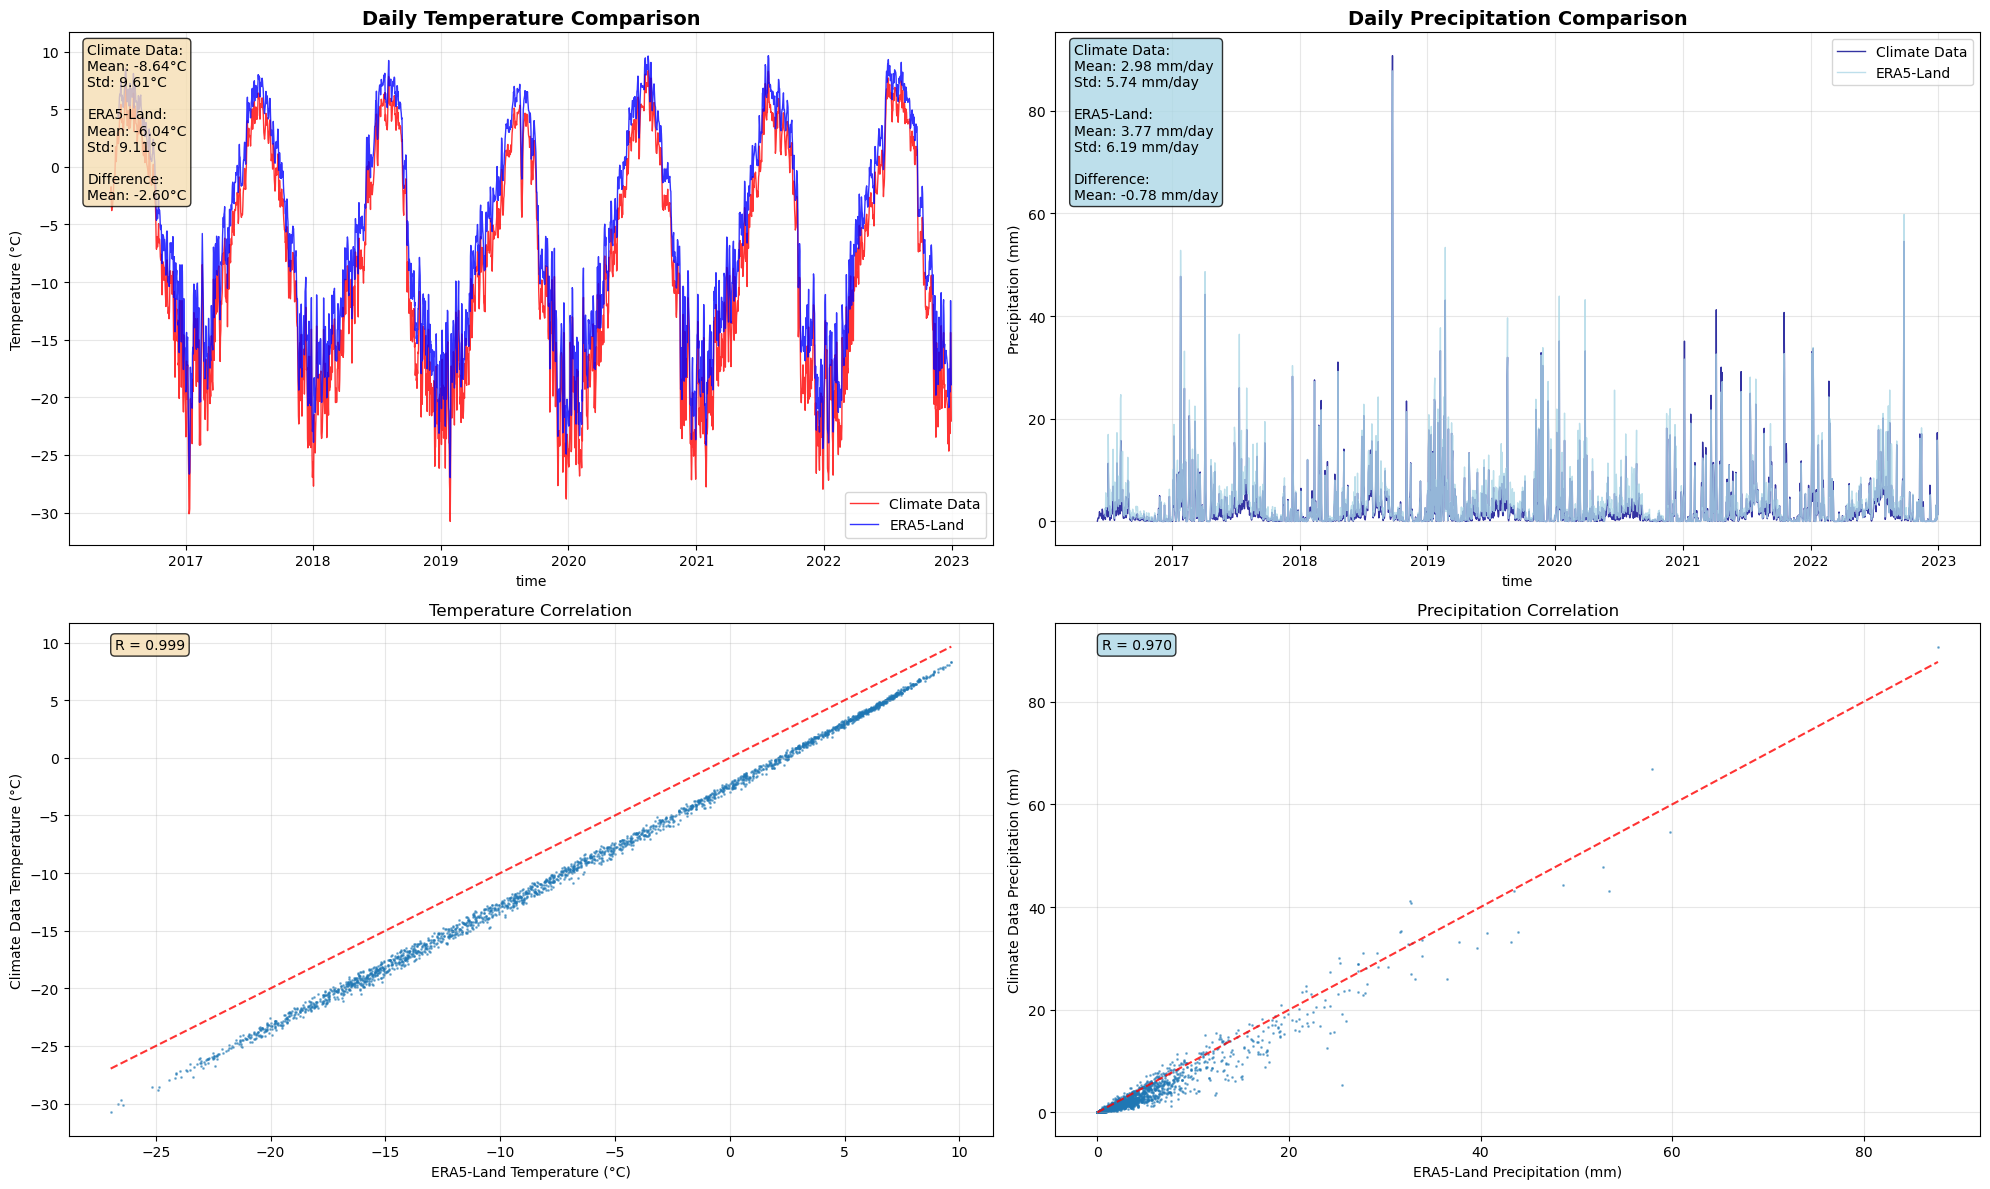


CLIMATE DATA vs ERA5-LAND COMPARISON

🌡️  TEMPERATURE COMPARISON:
  Climate Data Mean:    -8.64 °C
  ERA5-Land Mean:       -6.04 °C
  Mean Difference:      -2.60 °C
  Climate Data Std:     9.61 °C
  ERA5-Land Std:        9.11 °C
  Correlation:          0.999

🌧️  PRECIPITATION COMPARISON:
  Climate Data Mean:    2.98 mm/day
  ERA5-Land Mean:       3.77 mm/day
  Mean Difference:      -0.78 mm/day
  Climate Data Std:     5.74 mm/day
  ERA5-Land Std:        6.19 mm/day
  Correlation:          0.970

📅 TIME PERIOD:
  Climate Data:         2016-06-01T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
  ERA5-Land:            2016-06-22T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
  Common time steps:    2382


In [19]:
# Run the comparison
print("Comparing Climate Data with ERA5-Land...")
climate_temp_ts, climate_prec_ts, era5_temp_ts, era5_prec_ts = compare_time_series(
    climate_ds, era5_ds, save_path='climate_vs_era5_comparison.png'
)

In [25]:
# Plot ERA5-Land data separately
def plot_era5_time_series(era5_ds, save_path=None):
    """
    Plot ERA5-Land time series separately
    
    Parameters
    ----------
    era5_ds : xr.Dataset
        ERA5-Land dataset with temperature and precipitation
    save_path : str, optional
        Path to save the plot
    """
    # Calculate area-averaged time series
    era5_temp = era5_ds['temperature'].mean(dim=['latitude', 'longitude'])
    era5_prec = era5_ds['precipitation'].mean(dim=['latitude', 'longitude'])
    
    # Convert units if needed
    if era5_temp.max() > 100:  # Likely in Kelvin
        era5_temp = era5_temp - 273.15
        temp_unit = "°C (converted from K)"
    else:
        temp_unit = "°C"
    
    if era5_prec.max() < 1:  # Likely in meters
        era5_prec = era5_prec * 1000
        prec_unit = "mm (converted from m)"
    else:
        prec_unit = "mm"
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot temperature time series
    era5_temp.plot(ax=ax1, color='red', linewidth=1)
    ax1.set_title('ERA5-Land Daily Temperature Time Series', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'Temperature ({temp_unit})')
    ax1.grid(True, alpha=0.3)
    
    # Add temperature statistics as text
    temp_stats_text = f"Mean: {era5_temp.mean().values:.2f}°C\n"
    temp_stats_text += f"Std: {era5_temp.std().values:.2f}°C\n"
    temp_stats_text += f"Min: {era5_temp.min().values:.2f}°C\n"
    temp_stats_text += f"Max: {era5_temp.max().values:.2f}°C"
    
    ax1.text(0.02, 0.98, temp_stats_text, transform=ax1.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Plot precipitation time series
    era5_prec.plot(ax=ax2, color='darkblue', linewidth=1)
    ax2.set_title('ERA5-Land Daily Precipitation Time Series', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel(f'Precipitation ({prec_unit})')
    ax2.grid(True, alpha=0.3)
    
    # Add precipitation statistics as text
    prec_stats_text = f"Mean: {era5_prec.mean().values:.2f} mm/day\n"
    prec_stats_text += f"Std: {era5_prec.std().values:.2f} mm/day\n"
    prec_stats_text += f"Min: {era5_prec.min().values:.2f} mm/day\n"
    prec_stats_text += f"Max: {era5_prec.max().values:.2f} mm/day"
    
    ax2.text(0.02, 0.98, prec_stats_text, transform=ax2.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"ERA5-Land time series plot saved to {save_path}")
    
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("ERA5-LAND TIME SERIES STATISTICS")
    print("="*60)
    
    print(f"\n🌡️  TEMPERATURE TIME SERIES:")
    print(f"  Mean:     {era5_temp.mean().values:.2f} °C")
    print(f"  Std Dev:  {era5_temp.std().values:.2f} °C")
    print(f"  Minimum:  {era5_temp.min().values:.2f} °C on {era5_temp.idxmin().values}")
    print(f"  Maximum:  {era5_temp.max().values:.2f} °C on {era5_temp.idxmax().values}")
    
    print(f"\n🌧️  PRECIPITATION TIME SERIES:")
    print(f"  Mean:     {era5_prec.mean().values:.2f} mm/day")
    print(f"  Std Dev:  {era5_prec.std().values:.2f} mm/day") 
    print(f"  Minimum:  {era5_prec.min().values:.2f} mm/day on {era5_prec.idxmin().values}")
    print(f"  Maximum:  {era5_prec.max().values:.2f} mm/day on {era5_prec.idxmax().values}")
    
    # Calculate seasonal statistics
    temp_monthly = era5_temp.groupby('time.month').mean()
    prec_monthly = era5_prec.groupby('time.month').mean()
    
    print(f"\n📅 SEASONAL PATTERNS:")
    print(f"  Warmest month:  {temp_monthly.idxmax().values} ({temp_monthly.max().values:.2f}°C)")
    print(f"  Coldest month:  {temp_monthly.idxmin().values} ({temp_monthly.min().values:.2f}°C)")
    print(f"  Wettest month:  {prec_monthly.idxmax().values} ({prec_monthly.max().values:.2f} mm/day)")
    print(f"  Driest month:   {prec_monthly.idxmin().values} ({prec_monthly.min().values:.2f} mm/day)")
    
    # Calculate annual totals
    prec_annual = era5_prec.groupby('time.year').sum()
    temp_annual = era5_temp.groupby('time.year').mean()
    
    print(f"\n📊 ANNUAL STATISTICS:")
    print(f"  Years analyzed: {len(prec_annual)}")
    print(f"  Mean annual precipitation: {prec_annual.mean().values:.1f} mm/year")
    print(f"  Mean annual temperature:   {temp_annual.mean().values:.2f} °C")
    print(f"  Wettest year: {prec_annual.idxmax().values} ({prec_annual.max().values:.1f} mm)")
    print(f"  Driest year:  {prec_annual.idxmin().values} ({prec_annual.min().values:.1f} mm)")
    print(f"  Warmest year: {temp_annual.idxmax().values} ({temp_annual.max().values:.2f} °C)")
    print(f"  Coldest year: {temp_annual.idxmin().values} ({temp_annual.min().values:.2f} °C)")
    
    return era5_temp, era5_prec

def plot_era5_monthly_climatology(era5_ds, save_path=None):
    """Plot ERA5-Land monthly climatology"""
    # Calculate area-averaged time series
    era5_temp = era5_ds['temperature'].mean(dim=['latitude', 'longitude'])
    era5_prec = era5_ds['precipitation'].mean(dim=['latitude', 'longitude'])
    
    # Convert units if needed
    if era5_temp.max() > 100:
        era5_temp = era5_temp - 273.15
    if era5_prec.max() < 1:
        era5_prec = era5_prec * 1000
    
    # Calculate monthly climatology
    temp_monthly = era5_temp.groupby('time.month').mean()
    prec_monthly = era5_prec.groupby('time.month').mean()
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot temperature climatology
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    ax1.plot(range(1, 13), temp_monthly.values, 'bo-', linewidth=2, markersize=6)
    ax1.set_title('ERA5-Land Monthly Temperature Climatology', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels(months)
    ax1.grid(True, alpha=0.3)
    
    # Plot precipitation climatology
    ax2.bar(range(1, 13), prec_monthly.values, color='darkblue', alpha=0.7)
    ax2.set_title('ERA5-Land Monthly Precipitation Climatology', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Precipitation (mm/day)')
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(months)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"ERA5-Land monthly climatology plot saved to {save_path}")
    
    plt.show()

Plotting ERA5-Land time series...
ERA5-Land time series plot saved to era5_land_time_series.png


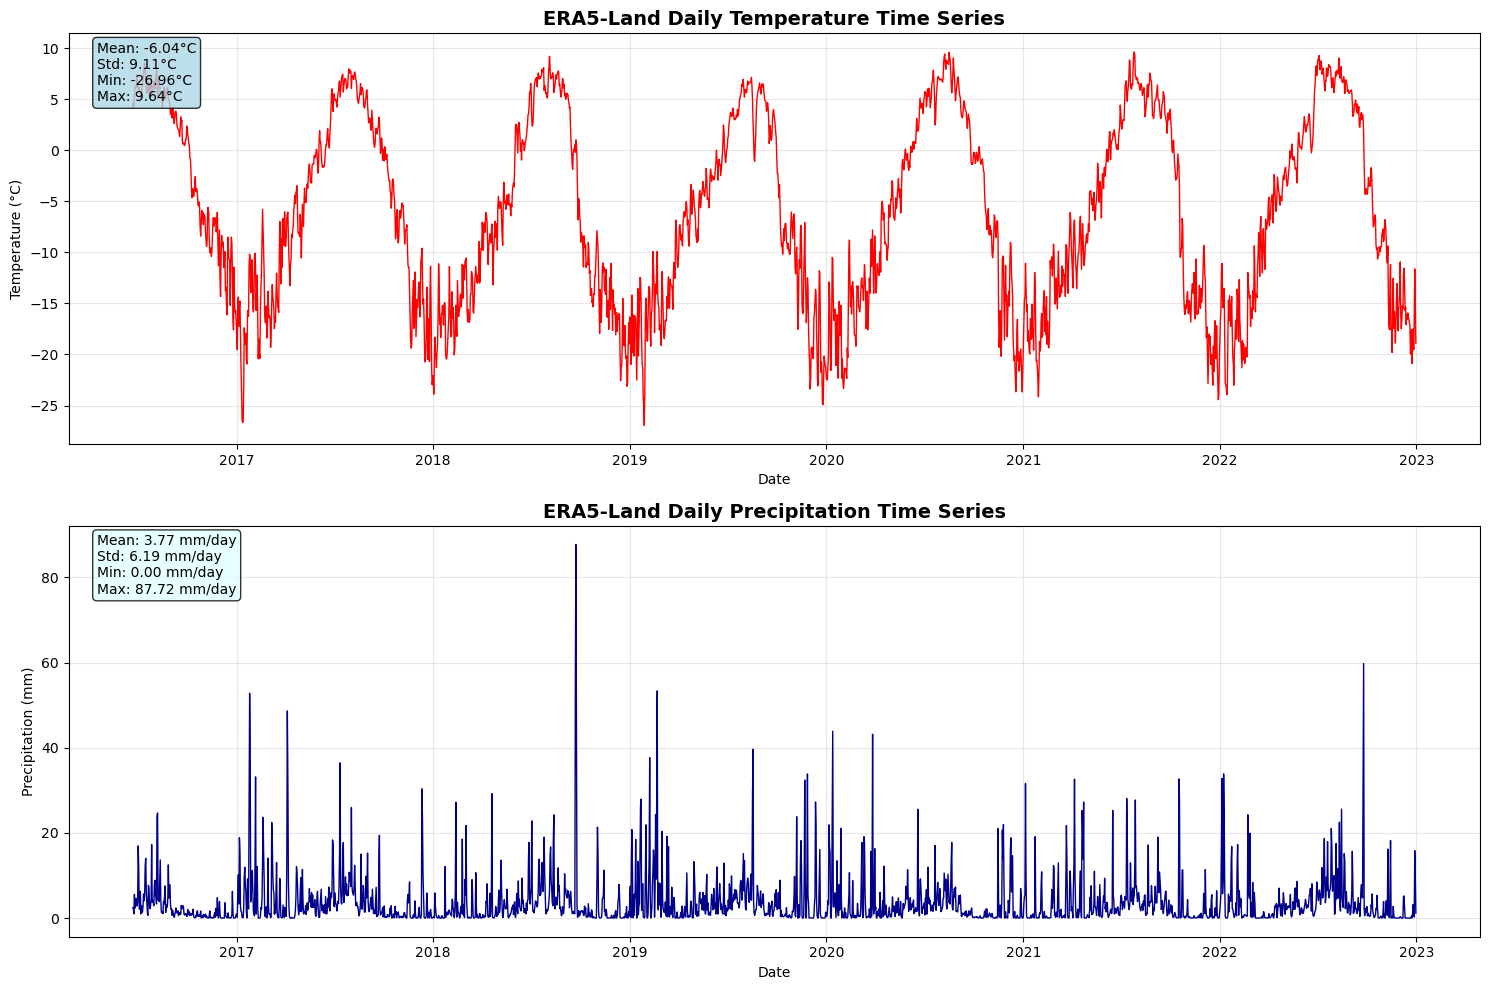


ERA5-LAND TIME SERIES STATISTICS

🌡️  TEMPERATURE TIME SERIES:
  Mean:     -6.04 °C
  Std Dev:  9.11 °C
  Minimum:  -26.96 °C on 2019-01-28T00:00:00.000000000
  Maximum:  9.64 °C on 2021-07-26T00:00:00.000000000

🌧️  PRECIPITATION TIME SERIES:
  Mean:     3.77 mm/day
  Std Dev:  6.19 mm/day
  Minimum:  0.00 mm/day on 2016-11-18T00:00:00.000000000
  Maximum:  87.72 mm/day on 2018-09-23T00:00:00.000000000

📅 SEASONAL PATTERNS:
  Warmest month:  8.0 (6.27°C)
  Coldest month:  1.0 (-17.73°C)
  Wettest month:  7.0 (6.31 mm/day)
  Driest month:   10.0 (1.25 mm/day)

📊 ANNUAL STATISTICS:
  Years analyzed: 7
  Mean annual precipitation: 1282.4 mm/year
  Mean annual temperature:   -5.71 °C
  Wettest year: 2019.0 (1682.8 mm)
  Driest year:  2016.0 (493.4 mm)
  Warmest year: 2016.0 (-1.20 °C)
  Coldest year: 2018.0 (-7.18 °C)


In [26]:
# Plot ERA5-Land data separately
print("Plotting ERA5-Land time series...")
era5_temp_ts, era5_prec_ts = plot_era5_time_series(era5_ds, 
                                                   save_path='era5_land_time_series.png')

Plotting ERA5-Land monthly climatology...


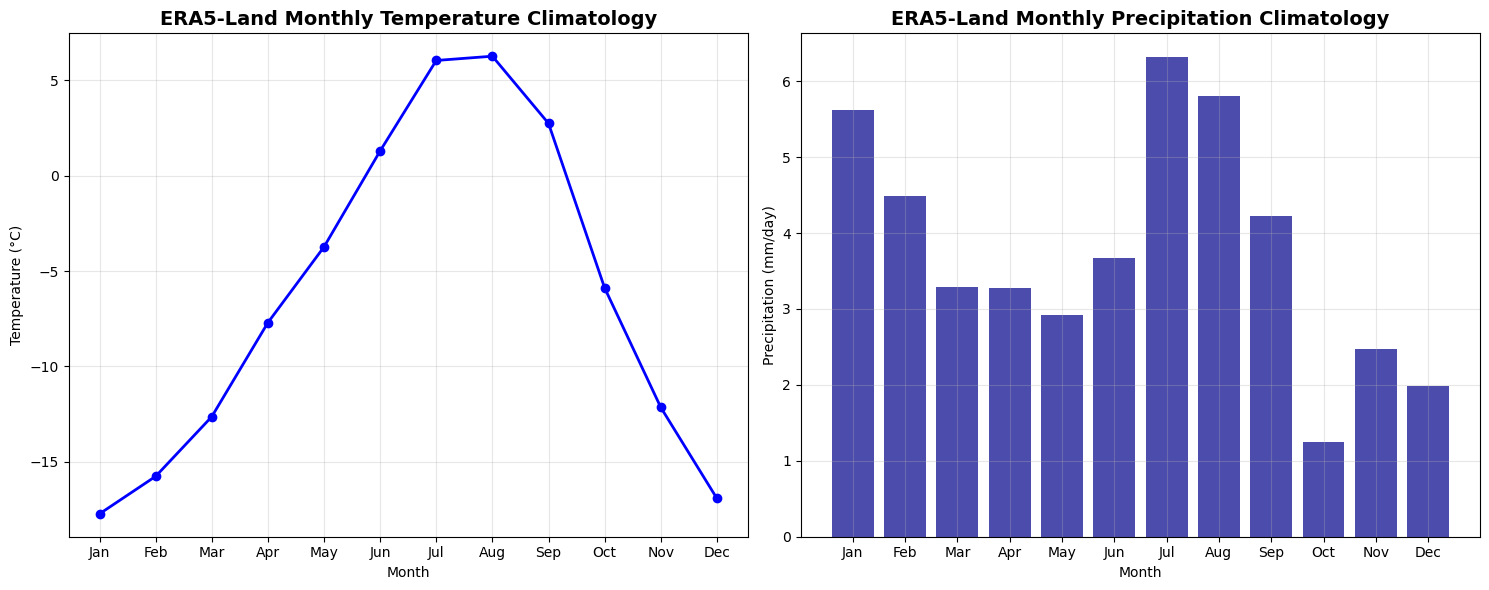

In [24]:
# Plot ERA5-Land data separately
print("Plotting ERA5-Land monthly climatology...")
plot_era5_monthly_climatology(era5_ds)

In [ ]:
### compare precip with precipition and look at temperature